In [32]:
!git clone https://github.com/Rafael-Orozco/Navegacion-Autonoma.git

fatal: destination path 'Navegacion-Autonoma' already exists and is not an empty directory.


In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten, Cropping2D
from sklearn.model_selection import train_test_split
import sklearn

**Cargar el dataset desde la carpeta captured_images**

In [34]:
data_dir = '/content/Navegacion-Autonoma/captured_images'
df = pd.read_csv(os.path.join(data_dir, 'log.csv'), header=None)
df.columns = ['center', 'steering']  # Asignar nombres de columnas manualmente

**Visualizar una imagen de ejemplo**

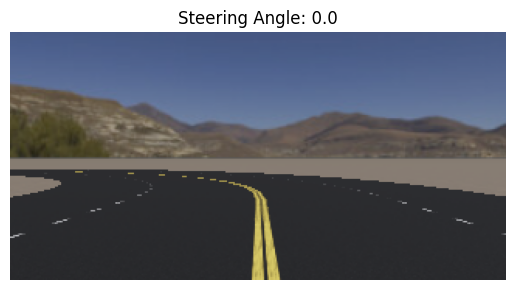

In [35]:
img_path = os.path.join(data_dir, df['center'][0].strip())

if os.path.isfile(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Steering Angle: {df['steering'][0]}")
    plt.axis('off')
    plt.show()
else:
    print(f"⚠️ Imagen no encontrada: {img_path}")

**Preprocesamiento y cambio de tamaño a 66x200 px**

In [36]:
def preprocess_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[60:-25, :, :]  # Recorte para eliminar cielo y capó

    # Suavizado para reducir ruido
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Escala de grises
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)

    # Detección de bordes con Canny
    edges = cv2.Canny(gray, 50, 150)

    # Detección de líneas rectas con Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=150)

    # Dibujar líneas sobre imagen original
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) > 20:  # Evitar líneas horizontales
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Superponer líneas sobre la imagen original
    combined = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    # Redimensionar a (200, 66, 3)
    resized = cv2.resize(combined, (200, 66))
    return resized

# Cargar y procesar las imágenes
images = []
angles = []

for i in range(len(df)):
    img_path = os.path.join(data_dir, df['center'][i].strip())
    if os.path.isfile(img_path):
        image = preprocess_image(img_path)
        angle = float(df['steering'][i])
        images.append(image)
        angles.append(angle)

X = np.array(images)
y = np.array(angles)


**Balanceo de datos: Eliminar exceso de datos con ángulo cercano a cero para balancear**

In [37]:
balanced_images = []
balanced_angles = []

zero_count = sum(np.abs(y) < 0.01)
max_zero = int(zero_count * 0.3)  # conservar solo 30% de ellos
kept_zero = 0

for img, ang in zip(X, y):
    if abs(ang) < 0.01:
        if kept_zero < max_zero:
            balanced_images.append(img)
            balanced_angles.append(ang)
            kept_zero += 1
    else:
        balanced_images.append(img)
        balanced_angles.append(ang)

X = np.array(balanced_images)
y = np.array(balanced_angles)

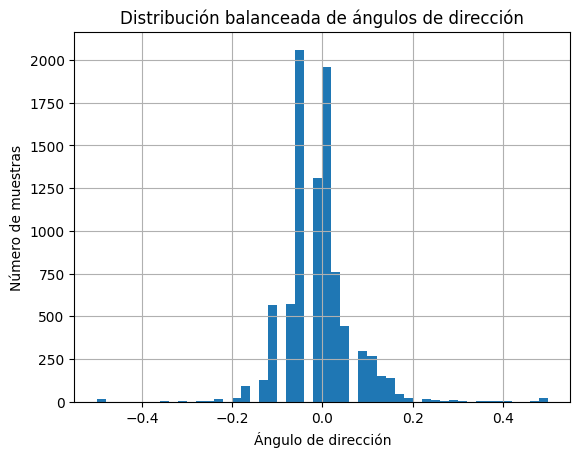

In [38]:
plt.hist(y, bins=50)
plt.title("Distribución balanceada de ángulos de dirección")
plt.xlabel("Ángulo de dirección")
plt.ylabel("Número de muestras")
plt.grid(True)
plt.show()

**Augmentation Technique**

In [39]:
def augment_image(image, angle):
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        angle = -angle
    return image, angle

def generate_batch(X, y, batch_size=32):
    while True:
        indices = np.random.permutation(len(X))
        for offset in range(0, len(X), batch_size):
            batch_indices = indices[offset:offset+batch_size]
            batch_images, batch_angles = [], []
            for i in batch_indices:
                image, angle = augment_image(X[i], y[i])
                batch_images.append(image)
                batch_angles.append(angle)
            yield np.array(batch_images), np.array(batch_angles)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True)

**Construcción del modelo NVIDIA**

In [40]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(66, 200, 3)))
model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compilar y entrenar el modelo**

In [41]:
model.compile(loss='mse', optimizer='adam')

train_generator = generate_batch(X_train, y_train)
valid_generator = generate_batch(X_valid, y_valid)

history = model.fit(train_generator,
                    steps_per_epoch=len(X_train)//32,
                    validation_data=valid_generator,
                    validation_steps=len(X_valid)//32,
                    epochs=5)


Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 47s 193ms/step - loss: 0.0086 - val_loss: 0.0052
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 367ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 366ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - loss: 0.0043 - val_loss: 0.0046


**Visualizar el entrenamiento**

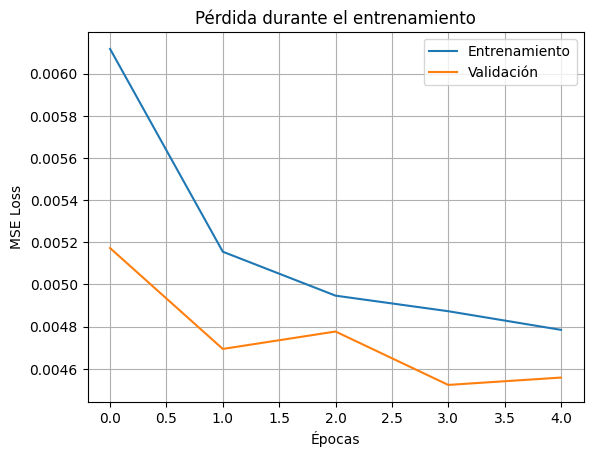

In [42]:
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

**Exportar modelo entrenado**

In [43]:
model.save('modelo_nvidia.h5')

**Descargar modelo entrenado para usar en Webots**

In [44]:
from google.colab import files
files.download('modelo_nvidia.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>